# Importar librerías + data

In [75]:
# import pandas as pd
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, models, utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [76]:
# Load data and change dtype
data = (
    pl.scan_parquet('datasets/teams/battlelog_train.parquet')
    ).collect()

data.columns

['event_mode',
 'event_map',
 'battle_type',
 'battle_duration',
 'battle_player1_tag',
 'battle_player1_brawler_name',
 'battle_player1_brawler_power',
 'battle_player1_brawler_trophies',
 'battle_player2_tag',
 'battle_player2_brawler_name',
 'battle_player2_brawler_power',
 'battle_player2_brawler_trophies',
 'battle_player3_tag',
 'battle_player3_brawler_name',
 'battle_player3_brawler_power',
 'battle_player3_brawler_trophies',
 'winner',
 'battle_player1_brawler_Health',
 'battle_player1_brawler_Rarity',
 'battle_player1_brawler_Class',
 'battle_player1_brawler_Movement_Speed',
 'battle_player1_brawler_Range',
 'battle_player1_brawler_Reload',
 'battle_player1_brawler_Speed_Num',
 'battle_player1_brawler_Range_Num',
 'battle_player1_brawler_Reload_Num',
 'battle_player1_brawler_Role',
 'battle_player2_brawler_Health',
 'battle_player2_brawler_Rarity',
 'battle_player2_brawler_Class',
 'battle_player2_brawler_Movement_Speed',
 'battle_player2_brawler_Range',
 'battle_player2_brawl

In [77]:
# subset dataframe
data = data[[
	'winner'
    ,'barriers'
	,'barriers_center'
	,'bushes'
	,'bushes_center'
	,'waterProp'
	,'event_mode'
	,'event_map'
	,'battle_player1_brawler_name'
	,'battle_player2_brawler_name'
	,'battle_player3_brawler_name'
    ,'battle_player1_brawler_Class'
	,'battle_player2_brawler_Class'
	,'battle_player3_brawler_Class'
	,'battle_player1_brawler_Role'
	,'battle_player2_brawler_Role'
	,'battle_player3_brawler_Role'
	,'battle_power'
	,'avg_brawler_trophies'
	,'brawler_trophies_min'
	,'brawler_trophies_max'
	,'avg_trophies'
	,'trophies_min'
	,'trophies_max'
	,'avg_highestTrophies'
	,'highestTrophies_min'
	,'highestTrophies_max'
	,'avg_brawler_Health'
	,'brawler_Health_min'
	,'brawler_Health_max'
	,'avg_brawler_winrate'
	,'brawler_winrate_min'
	,'brawler_winrate_max'
	,'avg_brawler_winrate_overall'
	,'brawler_winrate_overall_min'
	,'brawler_winrate_overall_max'
	,'avg_brawler_userate'
	,'brawler_userate_min'
	,'brawler_userate_max'
	,'avg_brawler_userate_overall'
	,'brawler_userate_overall_min'
	,'brawler_userate_overall_max'
	,'avg_team_victories'
	,'team_victories_min'
	,'team_victories_max'
	,'avg_expPoints'
	,'expPoints_min'
	,'expPoints_max'
	]]

Limpiar categorías

In [78]:
def one_hot_encoding(df, col, prefix):
	"""
	Función para convertir las etiquetas de texto a valores numéricos
	y luego convertir los valores numéricos a "one-hot encoding"
	"""	

	y = df[col]
	x = df.drop([col])

	le = LabelEncoder()
	y = le.fit_transform(y)

	# Convertir los valores numéricos a "one-hot encoding"
	y = pl.DataFrame(utils.to_categorical(y))

	y = y.select([pl.col('column_' + str(i)).alias(prefix + '_' + item) for i, item in enumerate(le.classes_)])
	
	# unir el dataframe con las categorias codificadas
	df_encoded = pl.concat([x, y], how='horizontal')

	return df_encoded

data = one_hot_encoding(data, 'event_mode', 'EV')
data = one_hot_encoding(data, 'event_map', 'MP')
data = one_hot_encoding(data, 'battle_player1_brawler_Class', 'C1')
data = one_hot_encoding(data, 'battle_player2_brawler_Class', 'C2')
data = one_hot_encoding(data, 'battle_player3_brawler_Class', 'C3')
data = one_hot_encoding(data, 'battle_player1_brawler_Role', 'R1')
data = one_hot_encoding(data, 'battle_player2_brawler_Role', 'R2')
data = one_hot_encoding(data, 'battle_player3_brawler_Role', 'R3')
data = one_hot_encoding(data, 'battle_player1_brawler_name', 'P1')
data = one_hot_encoding(data, 'battle_player2_brawler_name', 'P2')
data = one_hot_encoding(data, 'battle_player3_brawler_name', 'P3')
data

winner,barriers,barriers_center,bushes,bushes_center,waterProp,battle_power,avg_brawler_trophies,brawler_trophies_min,brawler_trophies_max,avg_trophies,trophies_min,trophies_max,avg_highestTrophies,highestTrophies_min,highestTrophies_max,avg_brawler_Health,brawler_Health_min,brawler_Health_max,avg_brawler_winrate,brawler_winrate_min,brawler_winrate_max,avg_brawler_winrate_overall,brawler_winrate_overall_min,brawler_winrate_overall_max,avg_brawler_userate,brawler_userate_min,brawler_userate_max,avg_brawler_userate_overall,brawler_userate_overall_min,brawler_userate_overall_max,avg_team_victories,team_victories_min,team_victories_max,avg_expPoints,expPoints_min,expPoints_max,...,P3_GALE,P3_GENE,P3_GRAY,P3_GRIFF,P3_GROM,P3_GUS,P3_JACKY,P3_JANET,P3_JESSIE,P3_LEON,P3_LOLA,P3_LOU,P3_MANDY,P3_MAX,P3_MEG,P3_MORTIS,P3_MR. P,P3_NANI,P3_NITA,P3_OTIS,P3_PAM,P3_PENNY,P3_PIPER,P3_POCO,P3_RICO,P3_ROSA,P3_RUFFS,P3_SAM,P3_SANDY,P3_SHELLY,P3_SPIKE,P3_SPROUT,P3_SQUEAK,P3_STU,P3_SURGE,P3_TARA,P3_TICK
bool,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
true,60,18,82,29,0.0,33.0,6.918036,6.715383,7.084226,10.888228,10.505451,11.263553,10.888352,10.505999,11.263553,8.594339,8.412055,8.839422,0.49073,0.452415,0.54712,0.502476,0.477947,0.535703,0.740007,0.576903,1.063193,1.031029,0.263347,1.698714,10.177616,8.68457,11.010002,12.85884,12.023405,13.526012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,33.0,6.996376,6.976348,7.035269,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.860925,8.507345,9.259226,0.538669,0.476378,0.59709,0.521462,0.473367,0.564274,0.666006,0.191798,1.193827,0.8383,0.352721,1.349106,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
true,60,18,82,29,0.0,33.0,6.987798,6.966967,7.028201,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.860925,8.507345,9.259226,0.538669,0.476378,0.59709,0.521462,0.473367,0.564274,0.666006,0.191798,1.193827,0.8383,0.352721,1.349106,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,32.0,6.841972,6.813445,6.857514,10.857575,10.58888,11.074343,10.892366,10.58888,11.156265,8.674368,8.507345,8.881975,0.481797,0.404844,0.524731,0.505076,0.461216,0.550531,0.527318,0.218226,1.053377,0.6029,0.344665,0.997353,9.952182,9.407058,10.560697,12.879975,12.533576,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,32.0,6.784457,6.651572,6.864848,10.857575,10.58888,11.074343,10.892366,10.58888,11.156265,8.537192,8.507345,8.594339,0.508889,0.404844,0.59709,0.509657,0.461216,0.564274,0.82181,0.218226,1.193827,0.937714,0.466684,1.349106,9.952182,9.407058,10.560697,12.879975,12.533576,13.29273,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
true,60,18,82,29,0.0,33.0,6.986258,6.966024,7.024649,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.507345,8.343078,8.648397,0.547552,0.503025,0.59709,0.525473,0.485399,0.564274,1.226045,0.612393,1.871915,1.184087,0.352721,1.850433,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Generar test split

In [79]:
seed=14690

data = data.to_pandas()

train, test = train_test_split(data, test_size = 0.8, random_state=seed)

print(str(train.shape) + " train samples")
print(str(test.shape) + " test samples")

(129477, 319) train samples
(517912, 319) test samples


# Entrenando y comparando diferentes modelos

In [80]:
model_1 = models.Sequential([
    layers.Dense(318, input_dim=318, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 318)               101442    
                                                                 
 dense_29 (Dense)            (None, 159)               50721     
                                                                 
 dense_30 (Dense)            (None, 159)               25440     
                                                                 
 dense_31 (Dense)            (None, 1)                 160       
                                                                 
Total params: 177,763
Trainable params: 177,763
Non-trainable params: 0
_________________________________________________________________


In [81]:
model_2 = models.Sequential([
    layers.Dense(636, input_dim=318, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 636)               202884    
                                                                 
 dense_33 (Dense)            (None, 159)               101283    
                                                                 
 dense_34 (Dense)            (None, 159)               25440     
                                                                 
 dropout_3 (Dropout)         (None, 159)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 160       
                                                                 
Total params: 329,767
Trainable params: 329,767
Non-trainable params: 0
_________________________________________________________________


Compilando modelos

In [82]:
optimizer = 'adam' # 'rmsprop' 'sgd'
loss = 'binary_crossentropy' # ideal para clasificación binaria
metrics = ['accuracy', 'mse', 'FalseNegatives', 'FalsePositives', 'TrueNegatives', 'TruePositives']

def compile_model(model):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

model_list = [model_1, model_2]

for model in model_list:
    compile_model(model)

Entrenando modelos

In [83]:
def train_models(model_list, train, epochs=500, verbose=False, batch_size=250):
	history_dict = {}
	for model in model_list:
		print('Iniciando entrenamiento ' + str(model.name))
		historial = model.fit(train.drop(['winner'], axis=1), train['winner'], epochs=epochs, verbose=verbose, batch_size=batch_size)
		history_dict[model.name] = historial.history
	return history_dict

trained_models = train_models(model_list, train)

Iniciando entrenamiento sequential_7
Iniciando entrenamiento sequential_8


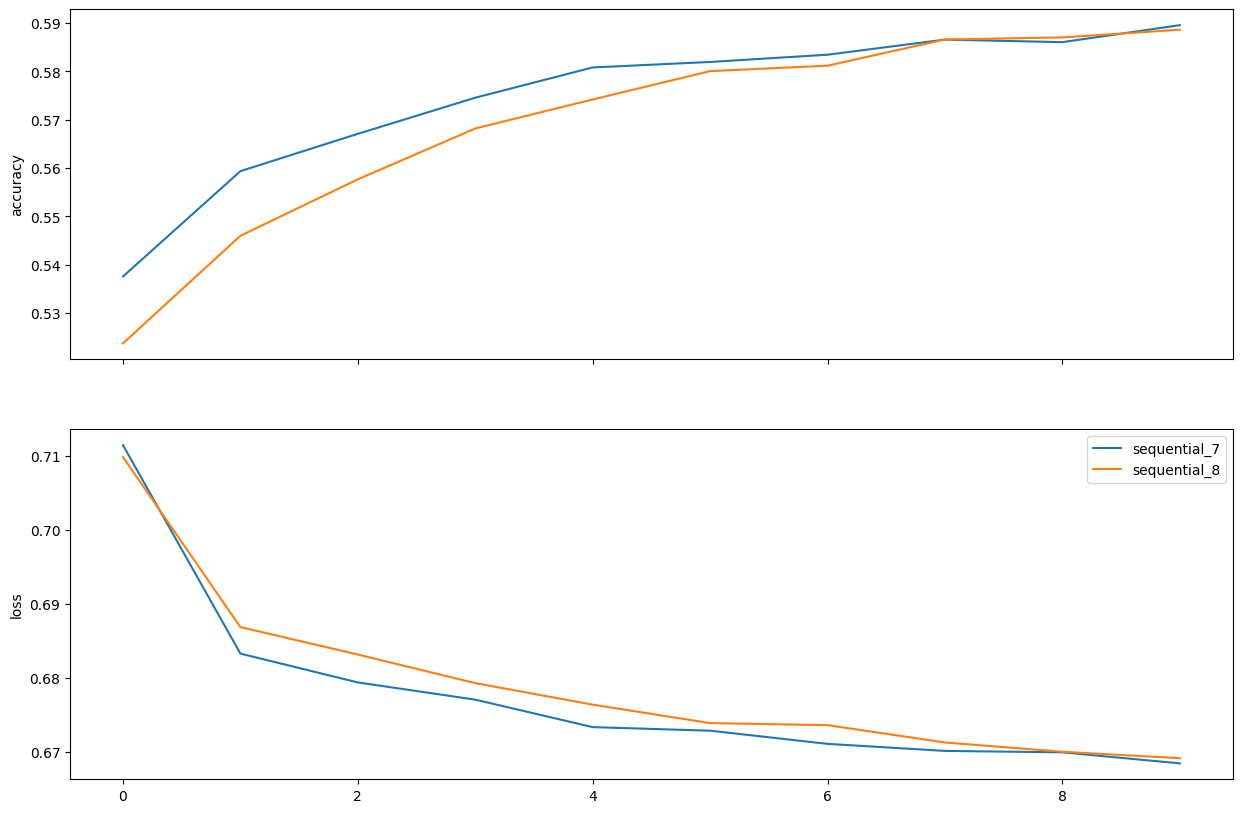

In [84]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("loss")

for model in trained_models:
	ax[0].plot(trained_models[model]['accuracy'], label=model)
	ax[1].plot(trained_models[model]['loss'], label=model)

plt.legend()

plt.show()

In [85]:
# resultado = model.predict([100.0])